

  0%|          | 0/400 [00:00<?, ?it/s]

             TSLA     GOOGL       MS      IBM       KO      CVX       HD  \
date                                                                       
2010-06-29  23.89  227.8333  20.1909  94.0708  18.8046  47.9884  22.9363   
2010-06-30  23.83  223.1639  19.9843  92.8600  18.7262  47.6374  22.4877   
2010-07-01  21.96  220.4254  19.8809  92.1757  18.6925  47.3706  22.3675   
2010-07-02  19.20  218.9509  19.6571  91.6417  18.7000  47.2513  22.2393   
2010-07-06  16.11  218.7101  19.7776  92.8450  18.8420  47.4268  21.9029   

                MCD  
date                 
2010-06-29  50.1788  
2010-06-30  49.7334  
2010-07-01  50.3676  
2010-07-02  49.9372  
2010-07-06  49.9146  
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)            



  0%|          | 1/400 [00:51<5:41:40, 51.38s/it]

  0%|          | 2/400 [01:41<5:37:49, 50.93s/it]

  1%|          | 3/400 [02:29<5:32:33, 50.26s/it]

  1%|          | 4/400 [03:20<5:31:35, 50.24s/it]

  1%|▏         | 5/400 [04:08<5:27:44, 49.78s/it]

  2%|▏         | 6/400 [04:57<5:24:33, 49.43s/it]

  2%|▏         | 7/400 [05:46<5:22:25, 49.23s/it]

  2%|▏         | 8/400 [06:33<5:18:12, 48.70s/it]

  2%|▏         | 9/400 [07:19<5:12:27, 47.95s/it]

  2%|▎         | 10/400 [08:05<5:07:32, 47.31s/it]

  3%|▎         | 11/400 [08:51<5:04:08, 46.91s/it]

  3%|▎         | 12/400 [09:37<5:01:37, 46.64s/it]

  3%|▎         | 13/400 [10:23<4:58:42, 46.31s/it]

  4%|▎         | 14/400 [11:08<4:55:06, 45.87s/it]

  4%|▍         | 15/400 [11:52<4:51:38, 45.45s/it]

  4%|▍         | 16/400 [12:38<4:51:12, 45.50s/it]

  4%|▍         | 17/400 [13:23<4:50:59, 45.59s/it]

  4%|▍         | 18/400 [14:09<4:51:01, 45.71s/it]

  5%|▍         | 19/400 [14:55<4:49:49, 45.64s/it]

  5%|▌         | 20

 35%|███▍      | 139/400 [1:44:51<3:17:00, 45.29s/it]

 35%|███▌      | 140/400 [1:45:36<3:15:14, 45.05s/it]

 35%|███▌      | 141/400 [1:46:21<3:13:54, 44.92s/it]

 36%|███▌      | 142/400 [1:47:06<3:13:51, 45.08s/it]

 36%|███▌      | 143/400 [1:47:51<3:13:38, 45.21s/it]

 36%|███▌      | 144/400 [1:48:40<3:16:55, 46.15s/it]

 36%|███▋      | 145/400 [1:49:26<3:16:01, 46.12s/it]

 36%|███▋      | 146/400 [1:50:12<3:14:51, 46.03s/it]

 37%|███▋      | 147/400 [1:50:56<3:12:19, 45.61s/it]

 37%|███▋      | 148/400 [1:51:41<3:10:13, 45.29s/it]

 37%|███▋      | 149/400 [1:52:25<3:08:30, 45.06s/it]

 38%|███▊      | 150/400 [1:53:11<3:08:41, 45.29s/it]

 38%|███▊      | 151/400 [1:54:05<3:18:39, 47.87s/it]

 38%|███▊      | 152/400 [1:54:57<3:22:31, 49.00s/it]

 38%|███▊      | 153/400 [1:55:43<3:17:43, 48.03s/it]

 38%|███▊      | 154/400 [1:56:29<3:15:03, 47.58s/it]

 39%|███▉      | 155/400 [1:57:15<3:12:30, 47.15s/it]

 39%|███▉      | 156/400 [1:58:04<3:13:57, 47.69s/it]

 39%|███▉ 

 68%|██████▊   | 273/400 [3:29:21<1:37:04, 45.86s/it]

 68%|██████▊   | 274/400 [3:30:06<1:35:14, 45.36s/it]

 69%|██████▉   | 275/400 [3:30:50<1:33:56, 45.09s/it]

 69%|██████▉   | 276/400 [3:31:35<1:32:54, 44.96s/it]

 69%|██████▉   | 277/400 [3:32:19<1:31:46, 44.77s/it]

 70%|██████▉   | 278/400 [3:33:03<1:30:44, 44.62s/it]

 70%|██████▉   | 279/400 [3:33:48<1:30:11, 44.72s/it]

 70%|███████   | 280/400 [3:34:32<1:29:06, 44.56s/it]

 70%|███████   | 281/400 [3:35:17<1:28:11, 44.47s/it]

 70%|███████   | 282/400 [3:36:02<1:28:11, 44.84s/it]

 71%|███████   | 283/400 [3:36:47<1:27:10, 44.71s/it]

 71%|███████   | 284/400 [3:37:31<1:26:20, 44.66s/it]

 71%|███████▏  | 285/400 [3:38:17<1:26:05, 44.92s/it]

 72%|███████▏  | 286/400 [3:39:09<1:29:13, 46.96s/it]

 72%|███████▏  | 287/400 [3:39:56<1:28:55, 47.22s/it]

 72%|███████▏  | 288/400 [3:40:43<1:27:49, 47.05s/it]

 72%|███████▏  | 289/400 [3:41:29<1:26:22, 46.69s/it]

 72%|███████▎  | 290/400 [3:42:15<1:25:06, 46.43s/it]

 73%|█████

------------------------------------------------------------
Testing
------------------------------------------------------------




100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


best stock pick:  MS


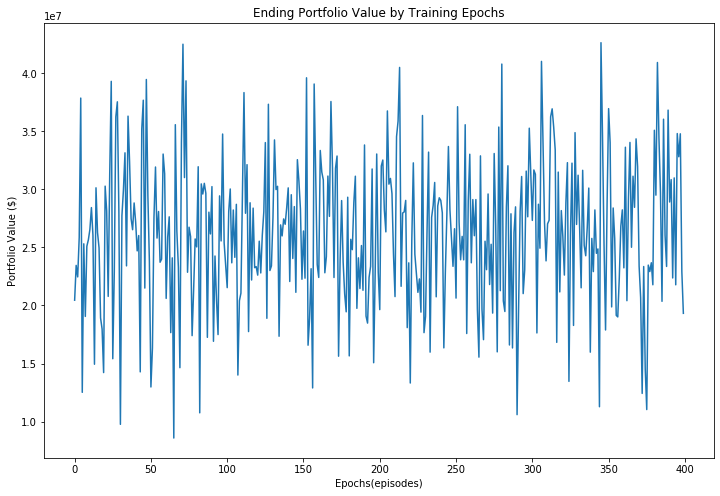

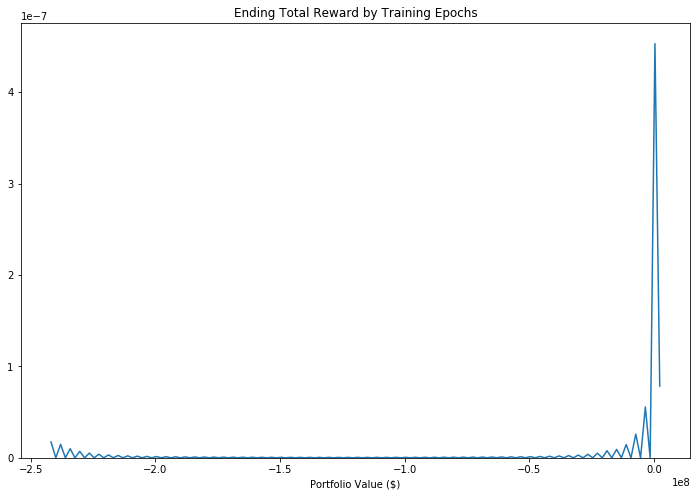

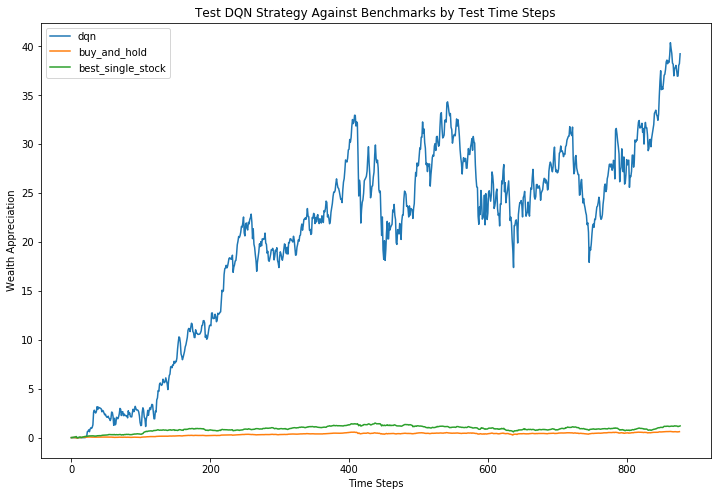

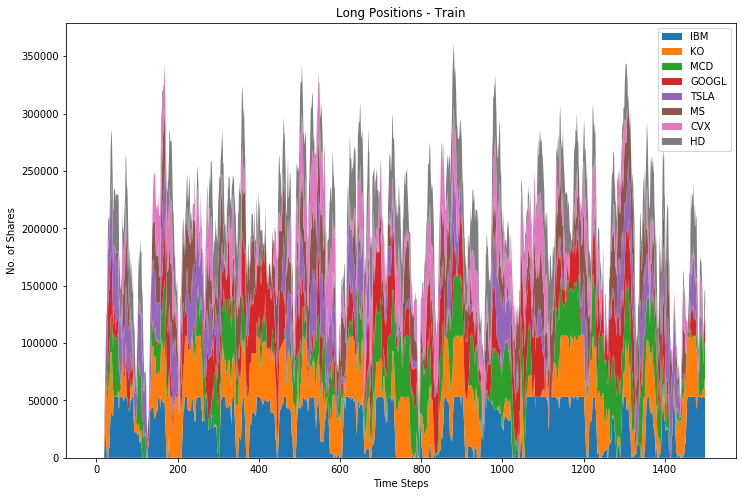

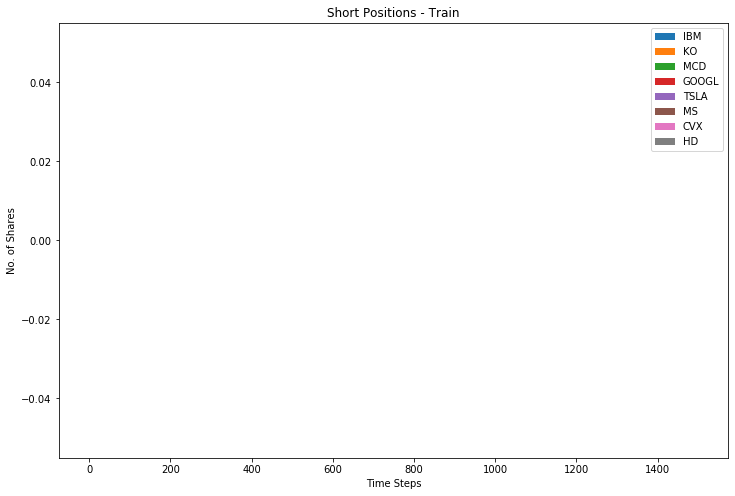

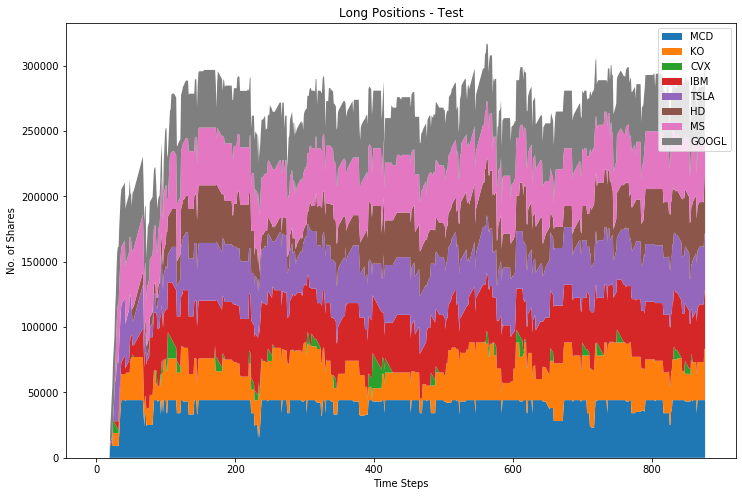

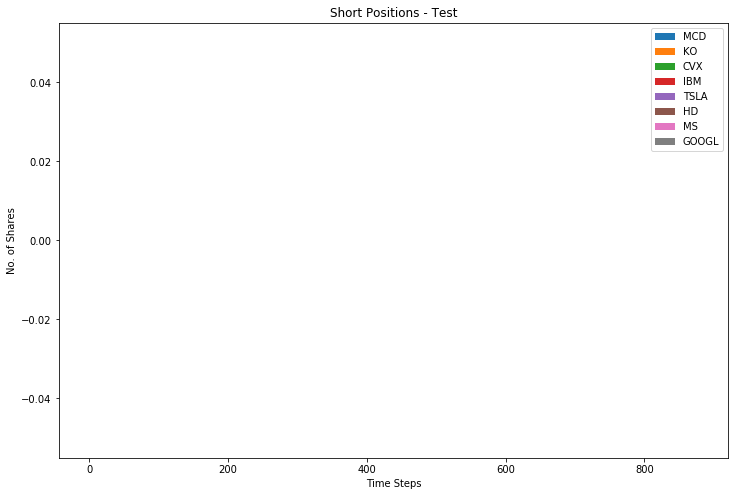

In [3]:
from environment import Market, get_ts
from model import Q_Model
from agent import Agent
from simulator import Simulator
from visualization import Visualize
import pandas as pd
import matplotlib.pyplot as plt

# sampler = Single_Signal_Generator(total_timesteps=180, period_range=(10, 40), amplitude_range=(5, 80), noise_amplitude_ratio=0.5)
# filename = "Generated Signals.npy"
# sampler.build_signals(filename, 1000)
# sampler.load(filename)
# env = Market(sampler=sampler, last_n_timesteps=40, trans_cost=3.3)

# ticker=['MS']
# ticker=['TSLA']
# ticker=['TSLA', 'GOOGL', 'MS', 'KO', 'CVX', 'HD', 'MMM' ,'BA']
# sample = get_ts(ticker)
# sample.to_csv('data/test/test_data_8stockmix.csv')
sample = pd.read_csv('data/test/test_data_8stockmix.csv', index_col=0)
# sample = pd.read_csv('data/test/test_data.csv', index_col=0)
print(sample.head())
# print(sample.shape)
# print(sample.dtypes)
env_train = Market(sample.iloc[:1500, :], 20, 0.5)
env_test = Market(sample.iloc[1500:, :], 20, 0.5)
# env.reset()

dense_model = [
    {"type":"Reshape", "target_shape":(env_train.get_state().shape[0]*env_train.get_state().shape[1],)},
    {"type":"Dense", "units":64*env_train.get_state().shape[1]},
    {"type":"Dense", "units":64}
]
conv_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"Conv1D", "filters":16, "kernel_size":3, "activation":"relu"},
    {"type":"Conv1D", "filters":16, "kernel_size":3, "activation":"relu"},
    {"type":"Flatten"},
    {"type":"Dense", "units":48, "activation":"relu"},
    {"type":"Dense", "units":24, "activation":"relu"}
]
gru_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"GRU", "units":16, "return_sequences":True},
    {"type":"GRU", "units":16, "return_sequences":False},
    {"type":"Dense", "units":16, "activation":"relu"},
    # {"type":"Dense", "units":16, "activation":"relu"}
]
lstm_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"LSTM", "units":16, "return_sequences":True},
    {"type":"LSTM", "units":16, "return_sequences":False},
    {"type":"Dense", "units":16, "activation":"relu"},
    # {"type":"Dense", "units":16, "activation":"relu"}
]

# user input
no_epochs = 400
model_name = 'Dense_8stock_longonly_ewa'
run_details = model_name + '_' + str(no_epochs) + '_eps'
# learning rate: 0.007
# experience replay batch_size = 16

# build model and agent
q_model = Q_Model(model_name, state_dim=env_train.get_state().shape, no_of_actions=env_train.no_of_actions, layers=dense_model, hyperparameters={"lr":0.007})
agent = Agent(q_model, batch_size=8, discount_factor=0.995, epsilon=1)

# train and test
sim = Simulator(env_train, agent)
ep_end_portf_val_train, last_eps_position_ts_train, exploration_episode_rewards_train = sim.train(no_epochs, epsilon_decay=0.995)

# save model snapshot 
agent.model.save() 

sim_test = Simulator(env_test, agent)
test_portf_val_ts, test_position_ts, test_ending_rewards = sim_test.test()

# visualize result
viz = Visualize(env_train, env_test, ep_end_portf_val_train, exploration_episode_rewards_train, run_details)
viz.save_test_results()

(-10000000, 10000000)

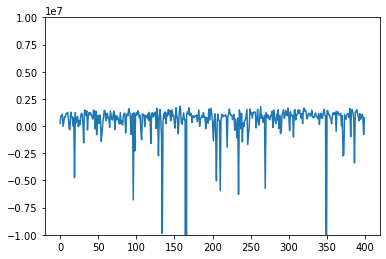

In [9]:
import numpy as np
plt.plot(np.sum(np.array(exploration_episode_rewards_train), axis=1))
plt.ylim(-10000000, 10000000)